<a href="https://colab.research.google.com/github/park-geun-hyeong/practice_pytorch/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

style_path = './style/starry_night.jpg'
content_path = './content/cat.jpg'

device = "cuda:0"
content_block = 4

### 1. Data preparation

In [6]:
type(Image.open(style_path))

PIL.JpegImagePlugin.JpegImageFile

In [7]:
def preprocess(img_dir): # HxWxC or CxHxW -> BxCxHxW (B=1)

    img = Image.open(img_dir)
    transform = transforms.Compose([
            transforms.ToTensor() 
    ])

    img = transform(img).view((-1,3 ,img.height, img.width)) # Batch, Channel, Height, Width
    return img 

In [8]:
def postprocess(tensor):  # BxCxHxW -> HxWxC 
    
    img = tensor.clone() ## grad 사용을 유지하고 싶을 경우
    img = img.clamp(0, 1) 
    img = torch.squeeze(img, dim=0)

    img = img.permute(1,2,0) 

    return img

In [9]:
content_img = preprocess(content_path).to(device)
style_img = preprocess(style_path).to(device)


generated_img = content_img.clone().requires_grad_().to(device)

### 2. Model preparation

In [10]:
vgg16 = models.vgg16(pretrained=True)

In [13]:
class VGG_FEATURE(nn.Module):
    def __init__(self):
        super(VGG_FEATURE, self).__init__()

        ## feature map들의 channel depth에 따라서 block 구분해주기
        self.block1 = nn.Sequential(*list(vgg16.features.children())[:3])
        self.block2 = nn.Sequential(*list(vgg16.features.children())[3:8])
        self.block3 = nn.Sequential(*list(vgg16.features.children())[8:15])
        self.block4 = nn.Sequential(*list(vgg16.features.children())[15:22])
        self.block5 = nn.Sequential(*list(vgg16.features.children())[22:29])

    def forward(self,x):
        
        out1 = self.block1(x)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        out5 = self.block5(out4)

        return out1, out2, out3, out4, out5

In [14]:
vgg_feature = VGG_FEATURE()
for param in vgg_feature.parameters():
    param.requires_grad = False

vgg_feature = vgg_feature.to(device)

### 3. Loss function and optimization method

In [16]:
# 각각의 Conv Block들을 channel x channel shape으로 바꾸어주기 위함

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b,c,h*w)
        G = torch.bmm(F, F.transpose(1,2))  ## Batch Matrix Multiplication ==> (Batch, Channel, Channel)
        
        return G

gramMatrix = GramMatrix()

In [17]:
class GramMSELoss(nn.Module): ## shape : Channel x Channel
    def forward(self, input, target): # input: feature map, target: target gram matrix
        loss_fn = nn.MSELoss()
        loss = loss_fn(gramMatrix(input), target) 
        return loss

In [18]:
style_target = list(gramMatrix(feature_map).to(device) for feature_map in vgg_feature(style_img))
content_target = vgg_feature(content_img)[content_block - 1]
style_weight = [ 1/(n**2)   for n in [64,128,256,512,512] ]

In [19]:
optimizer = torch.optim.Adam([generated_img], lr=0.01) 

### 4. Image generation

In [20]:
for epoch in range(1000):
    optimizer.zero_grad()
    out = vgg_feature(generated_img)

    ## style loss ##
    style_loss = [GramMSELoss().to(device)(out[i], style_target[i]) * style_weight[i] for i in range(5)]

    ## content loss ##
    content_loss = nn.MSELoss().to(device)(out[content_block -1], content_target)

    ## total loss ##
    total_loss = 10 * sum(style_loss) + torch.mean(content_loss)

    total_loss.backward()
    if epoch % 100 == 0:
        print(f"epoch : {epoch + 1}, loss: {total_loss.item():.6f}")

    optimizer.step()

epoch : 1, loss: 598428.187500
epoch : 101, loss: 1657.664551
epoch : 201, loss: 769.426697
epoch : 301, loss: 458.065857
epoch : 401, loss: 317.266266
epoch : 501, loss: 241.138962
epoch : 601, loss: 193.570862
epoch : 701, loss: 160.861969
epoch : 801, loss: 136.787781
epoch : 901, loss: 118.522041


##Style Transfer ==> Content : Cat,  Style : Starry Night 

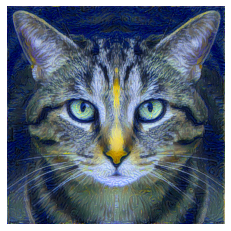

In [21]:
gen_img = postprocess(generated_img.cpu()).data.numpy()

plt.imshow(gen_img)
plt.axis(False)
plt.show()